<a href="https://colab.research.google.com/github/JaymeNeto/nlp-tweets-disaster-detection/blob/master/nlp_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential


import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#  for filename in filenames:
#    print(os.path.join(dirname, filename))


pd.set_option('max_colwidth', 400) # reset the total caracters on pandas to max of tweeter
nltk.download('stopwords');
nltk.download('wordnet');

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [6]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/drive/My Drive/Notebooks/Kaggle/nlp-tweets-disaster/glove.twitter.27B.200d.txt'), encoding = "utf-8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split() #split at space
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32') #numpy.asarray()function is used when we want to convert input to an array.
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 1193514 word vectors.


In [7]:
train_df = pd.read_csv('/content/drive/My Drive/Notebooks/Kaggle/nlp-tweets-disaster/train.csv', index_col='id')
test_df = pd.read_csv('/content/drive/My Drive/Notebooks/Kaggle/nlp-tweets-disaster/test.csv', index_col='id')

In [8]:
train_df.isnull().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

# EDA

In [9]:
print(train_df.shape)
print(test_df.shape)

(7613, 4)
(3263, 3)


In [10]:
train_sentences = train_df.text.values
train_labels = train_df.target.values
test_sentences = test_df.text.values

In [11]:
train_size = len(train_sentences)
train_size

7613

# Tokenizing text

In [12]:
import string
import re
punctuation = re.sub('(<|>)', '', string.punctuation)


#remove html tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

#remove urls
def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'<URL>',text)

def remove_numbers(text):
  numbers = re.compile('[-+]?[.\d]*[\d]+[:,.\d]*')
  return numbers.sub(r'<NUMBER>',text)

def remove_user(text):
  user = re.compile(r'@\w+')
  return user.sub('<USER>', text)

def remove_hastag(text):
  hastag = re.compile(r'#\S+')
  list_hastag = hastag.findall(text)
  list_hastag = list(set(list_hastag))
  for h in list_hastag:
    try:
      text = re.sub(h, '<HASTAG> ' + h[1:], text)
    except:
      continue
  return text

# splitting the text
def split_text(text):
    text = text.split()
    return text

 # making lower case words
def lower(text):
    text = [word.lower() for word in text]
    return str(text)

#remove punct
def remove_punct(text):
    text = ''.join([char for char in text if char not in punctuation])
    text = re.sub('[0-9]+', '', str(text))
    return text


#remove stopwords
def remove_stopwords(text):
    pattern = re.compile(r'\b('+r'|'.join(stopwords.words('english')) + r')\b\s*')
    text = pattern.sub(' ', text)
    return text

#lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    text = lemmatizer.lemmatize(text)
    return text

In [13]:
def final(text):
    t0 = remove_html(text)
    t1 = remove_urls(t0)
    t2 = remove_user(t1)
    t3 = remove_numbers(t2)
    t4 = remove_hastag(t3)
    t5 = split_text(t4)
    t6 = lower(t5)
    t7 = remove_punct(t6)
    t8 = remove_stopwords(t7)
    t9 = lemmatize_words(t8)
    return t9

In [14]:
training_sentences = []
for i in range(len(train_sentences)):
    data = final(train_sentences[i])
    training_sentences.append(data)

testing_sentences = []
for i in range(len(test_sentences)):
    data = final(test_sentences[i])
    testing_sentences.append(data)

In [16]:
train_df.insert(3, 'processed_tweets', training_sentences)

In [17]:
train_df

,keyword,location,text,processed_tweets,target
id,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,deeds reason <hastag> earthquake may allah forgive us,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,residents asked shelter place notified officers evacuation shelter place orders expected,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",<number> people receive <hastag> wildfires evacuation orders california,1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,got sent photo ruby <hastag> alaska smoke <hastag> wildfires pours school,1
...,...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,two giant cranes holding bridge collapse nearby homes <url>,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,<user> <user> control wild fires california even northern part state troubling,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,<number> <number> utc<number>km volcano hawaii <url>,1


# Handling duplicate conficting tweets

In [43]:
count_tweets = train_df.value_counts(subset=['processed_tweets'])
repeat_tweets = count_tweets[count_tweets.gt(1)]

count_tweets_targets = train_df.value_counts(subset=['processed_tweets', 'target'])
repeat_tweets_targets = count_targets[count_tweets_targets.gt(1)].reset_index()

In [63]:
confli_tweets = []
for tweet in repeat_tweets.index:
  tweet = tweet[0]
  rept = len(repeat_tweets_targets[repeat_tweets_targets.processed_tweets == tweet])
  if rept > 1:
    confli_tweets.append(tweet)

In [72]:
train_df = train_df[~train_df.processed_tweets.isin(confli_tweets)]
train_df_v2 = train_df.drop_duplicates()

# Padded

In [15]:
num_words = 25000
embedding_dim = 200
max_length = 32
trunc_type='post'
padding_type='post'
oov_tok = 'OOV'

tokenizer = Tokenizer(num_words=num_words, oov_token=oov_tok, filters=punctuation)
tokenizer.fit_on_texts(training_sentences)
train_sequences = tokenizer.texts_to_sequences(training_sentences)

word_index = tokenizer.word_index
padded_train = pad_sequences(sequences=train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print('Total unique tokens generated: ',len(word_index))
print('Shape of padded train tensor: ', padded_train.shape)

#tokenizer = Tokenizer(num_words=num_words, oov_token=oov_tok)
#tokenizer.fit_on_texts(testing_sentences)
test_sequences = tokenizer.texts_to_sequences(testing_sentences)
padded_test = pad_sequences(sequences=test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print('Shape of padded test tensor: ', padded_test.shape)

Total unique tokens generated:  15107
Shape of padded train tensor:  (7613, 32)
Shape of padded test tensor:  (3263, 32)


# Traning model

In [73]:
num_words = min(20000, len(word_index)+1)
embedding_matrix = np.zeros((num_words, embedding_dim))

embeddings = []
for word, i in word_index.items():
    if i<20000:
        embeddings = word2vec.get(word)
        if embeddings is not None:
            embedding_matrix[i] = embeddings

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

#checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words,
                              output_dim = embedding_dim,
                              weights=[embedding_matrix],
                              input_length=max_length,
                              trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])



model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 200)           3018400   
_________________________________________________________________
global_average_pooling1d (Gl (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                4824      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 3,023,249
Trainable params: 4,849
Non-trainable params: 3,018,400
_________________________________________________________________


In [ ]:
history_10=model.fit(padded_train,
                  train_labels,
                  validation_split=0.15,
                  batch_size=10,
                  epochs=15)

Epoch 1/15
648/648 [==============================] - 1s 2ms/step - loss: 0.5131 - accuracy: 0.7738 - val_loss: 0.4404 - val_accuracy: 0.7968
Epoch 2/15
648/648 [==============================] - 1s 2ms/step - loss: 0.4415 - accuracy: 0.8037 - val_loss: 0.4339 - val_accuracy: 0.7986
Epoch 3/15
648/648 [==============================] - 1s 2ms/step - loss: 0.4283 - accuracy: 0.8108 - val_loss: 0.4332 - val_accuracy: 0.7951
Epoch 4/15
648/648 [==============================] - 1s 1ms/step - loss: 0.4218 - accuracy: 0.8129 - val_loss: 0.4328 - val_accuracy: 0.7916
Epoch 5/15
648/648 [==============================] - 1s 1ms/step - loss: 0.4173 - accuracy: 0.8150 - val_loss: 0.4345 - val_accuracy: 0.8021
Epoch 6/15
648/648 [==============================] - 1s 1ms/step - loss: 0.4130 - accuracy: 0.8146 - val_loss: 0.4327 - val_accuracy: 0.7968
Epoch 7/15
648/648 [==============================] - 1s 1ms/step - loss: 0.4089 - accuracy: 0.8200 - val_loss: 0.4325 - val_accuracy: 0.8082
Epoch 

In [ ]:
history_100=model.fit(padded_train,
                  train_labels,
                  validation_split=0.15,
                  batch_size=100,
                  epochs=15)

Epoch 1/15
65/65 [==============================] - 0s 3ms/step - loss: 0.3788 - accuracy: 0.8346 - val_loss: 0.4364 - val_accuracy: 0.8056
Epoch 2/15
65/65 [==============================] - 0s 3ms/step - loss: 0.3769 - accuracy: 0.8368 - val_loss: 0.4367 - val_accuracy: 0.8039
Epoch 3/15
65/65 [==============================] - 0s 3ms/step - loss: 0.3763 - accuracy: 0.8379 - val_loss: 0.4369 - val_accuracy: 0.8039
Epoch 4/15
65/65 [==============================] - 0s 3ms/step - loss: 0.3760 - accuracy: 0.8370 - val_loss: 0.4371 - val_accuracy: 0.8039
Epoch 5/15
65/65 [==============================] - 0s 3ms/step - loss: 0.3758 - accuracy: 0.8371 - val_loss: 0.4373 - val_accuracy: 0.8047
Epoch 6/15
65/65 [==============================] - 0s 3ms/step - loss: 0.3753 - accuracy: 0.8374 - val_loss: 0.4375 - val_accuracy: 0.8039
Epoch 7/15
65/65 [==============================] - 0s 3ms/step - loss: 0.3751 - accuracy: 0.8385 - val_loss: 0.4377 - val_accuracy: 0.8056
Epoch 8/15
65/65 [==

In [ ]:
history_500=model.fit(padded_train,
                  train_labels,
                  validation_split=0.15,
                  batch_size=500,
                  epochs=15)

Epoch 1/15
13/13 [==============================] - 0s 10ms/step - loss: 0.3713 - accuracy: 0.8399 - val_loss: 0.4387 - val_accuracy: 0.8039
Epoch 2/15
13/13 [==============================] - 0s 9ms/step - loss: 0.3711 - accuracy: 0.8388 - val_loss: 0.4387 - val_accuracy: 0.8047
Epoch 3/15
13/13 [==============================] - 0s 8ms/step - loss: 0.3710 - accuracy: 0.8396 - val_loss: 0.4388 - val_accuracy: 0.8039
Epoch 4/15
13/13 [==============================] - 0s 8ms/step - loss: 0.3708 - accuracy: 0.8394 - val_loss: 0.4387 - val_accuracy: 0.8047
Epoch 5/15
13/13 [==============================] - 0s 8ms/step - loss: 0.3708 - accuracy: 0.8401 - val_loss: 0.4387 - val_accuracy: 0.8056
Epoch 6/15
13/13 [==============================] - 0s 8ms/step - loss: 0.3708 - accuracy: 0.8399 - val_loss: 0.4388 - val_accuracy: 0.8047
Epoch 7/15
13/13 [==============================] - 0s 8ms/step - loss: 0.3706 - accuracy: 0.8401 - val_loss: 0.4388 - val_accuracy: 0.8056
Epoch 8/15
13/13 [=

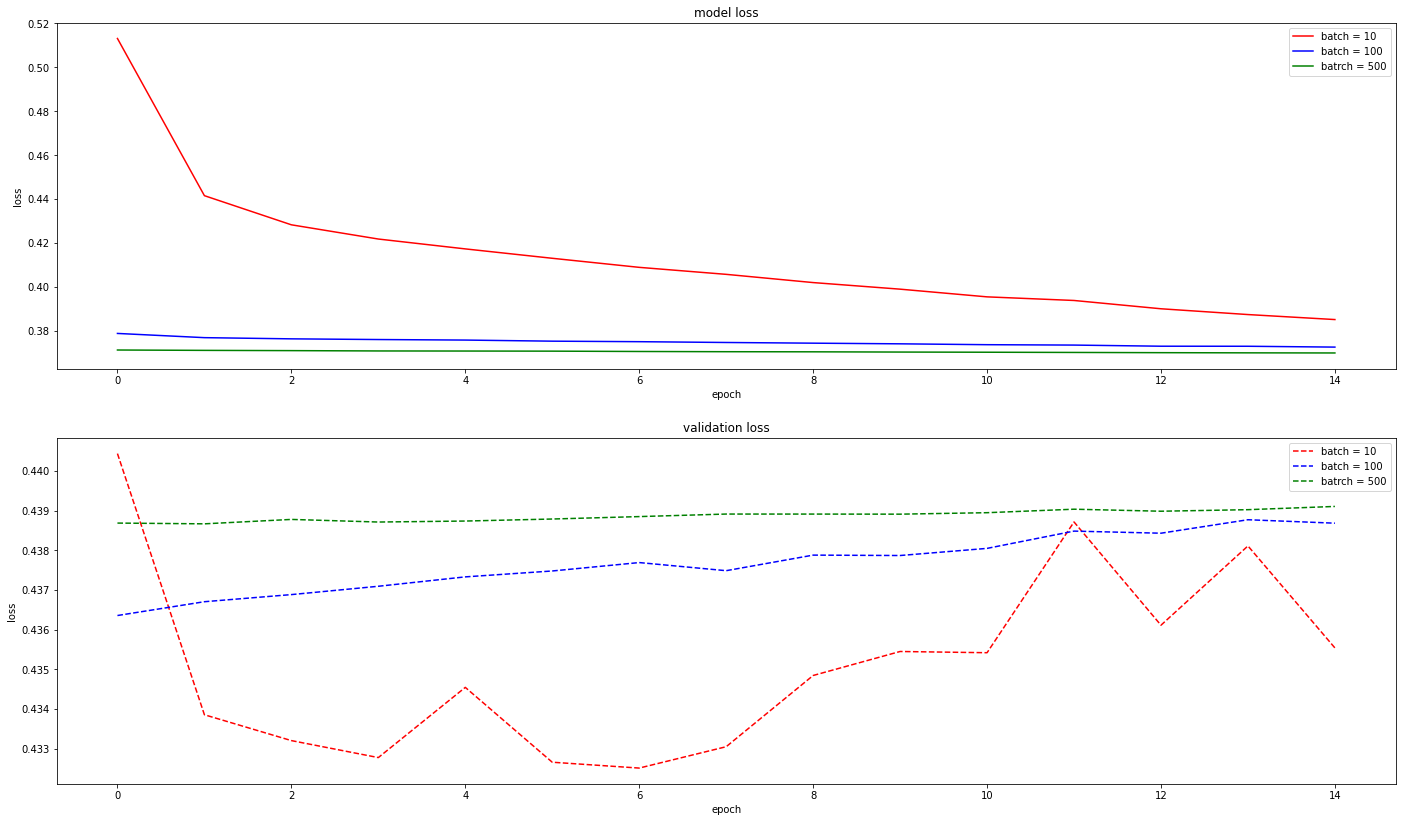

In [ ]:
from matplotlib import pyplot
pyplot.figure(figsize=(24,14))
pyplot.subplot(211)
#pyplot.figure(figsize=(24,14))
pyplot.plot(history_10.history['loss'],'r')
pyplot.plot(history_100.history['loss'],'b')
pyplot.plot(history_500.history['loss'],'g')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['batch = 10','batch = 100', 'batrch = 500'], loc='upper right')
pyplot.title('model loss')
pyplot.subplot(212)
#pyplot.figure(figsize=(24,14))
pyplot.plot(history_10.history['val_loss'],'r--')
pyplot.plot(history_100.history['val_loss'],'b--')
pyplot.plot(history_500.history['val_loss'],'g--')
pyplot.title('validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['batch = 10','batch = 100', 'batrch = 500'], loc='upper right')
#pyplot.legend(['train batch = 50', 'validation batrch = 50','train batch = 100', 'validation batrch = 100','train batch = 500', 'validation batrch = 500'], loc='upper right')
pyplot.show()

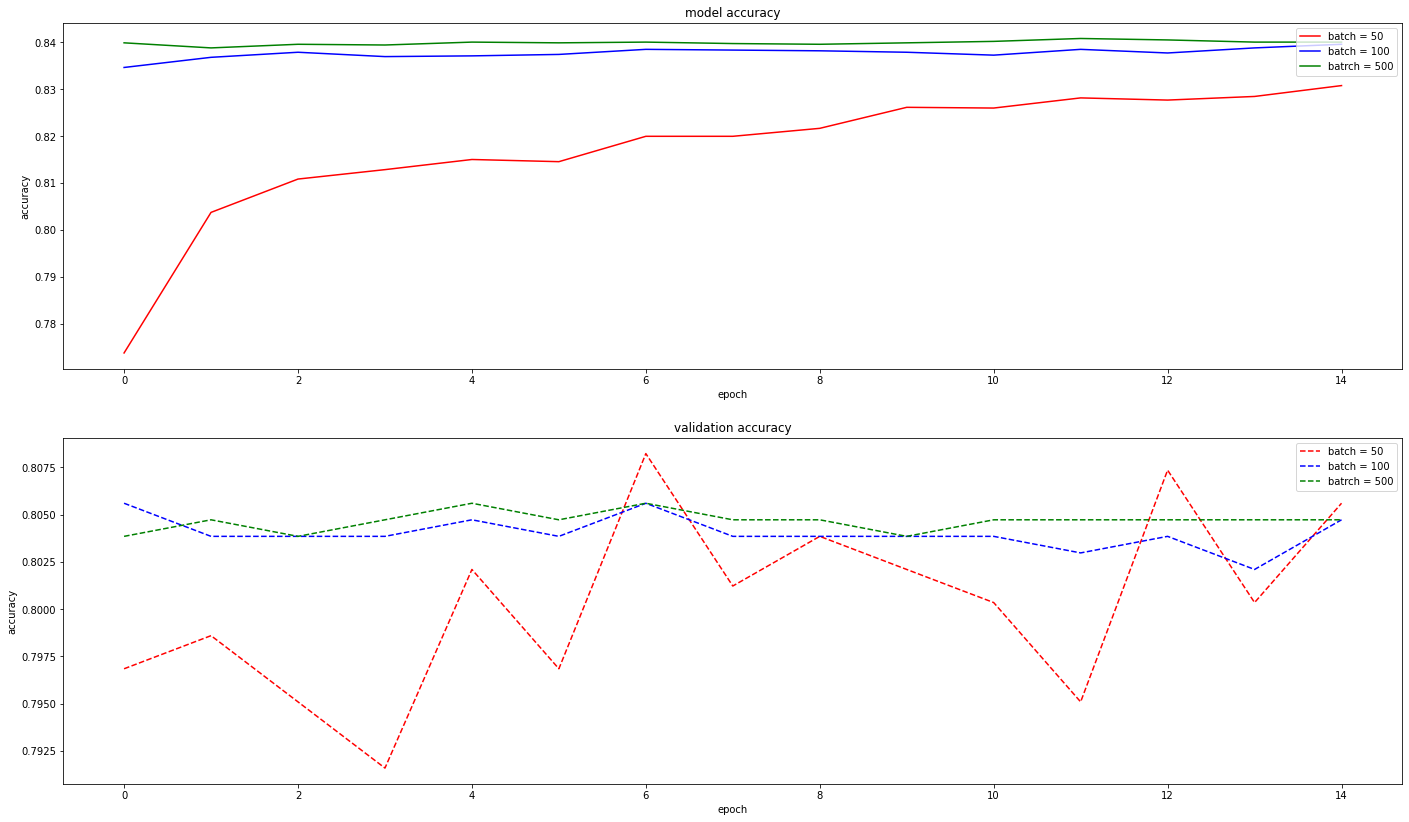

In [ ]:
pyplot.figure(figsize=(24,14))
pyplot.subplot(211)
#pyplot.figure(figsize=(24,14))
pyplot.plot(history_10.history['accuracy'],'r')
pyplot.plot(history_100.history['accuracy'],'b')
pyplot.plot(history_500.history['accuracy'],'g')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['batch = 50','batch = 100', 'batrch = 500'], loc='upper right')
pyplot.title('model accuracy')
pyplot.subplot(212)
#pyplot.figure(figsize=(24,14))
pyplot.plot(history_10.history['val_accuracy'],'r--')
pyplot.plot(history_100.history['val_accuracy'],'b--')
pyplot.plot(history_500.history['val_accuracy'],'g--')
pyplot.title('validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['batch = 50','batch = 100', 'batrch = 500'], loc='upper right')
#pyplot.legend(['train batch = 50', 'validation batrch = 50','train batch = 100', 'validation batrch = 100','train batch = 500', 'validation batrch = 500'], loc='upper right')
pyplot.show()

In [ ]:
pred = model.predict(padded_test)
pred = (np.round(pred)).astype(int)
pred = pred.reshape(3263)

In [ ]:
my_submission = pd.DataFrame({'id': test_df.id, 'target': pred})
my_submission.to_csv('submission5.csv', index=False)